In [1]:
# Import necessary libraries
import weather 
import wrangling
import integrity
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [2]:
date_start = '2018-01' #YYYY-MM format
date_end = '2018-12' #YYYY-MM format
path, parent_path = wrangling.acquire(date_start, date_end) # Web-scraping with selenium
wrangling.combine_csv(path, parent_path) # Shell script to concatenate csv files

Browsing the website...
Downloading...


In [3]:
df, airport, icao, n, d = wrangling.import_csv(path, date_start, date_end) # Import all csv files
rows = len(df)
print('Number of rows in dataframe is {}'.format(rows)) # Initial number of rows

2018.csv is imported
All csv files are concatenated
Number of rows in dataframe is 7213446


In [5]:
df, airport, flag, date_flag = wrangling.init_check(
    df, airport, date_start, date_end, d) # Initial check for columns

Initial check is completed


In [6]:
df = wrangling.recover(df, airport, flag, date_flag, n, d) # Impute data as much as possible

Recovering data has completed in 226.65 seconds


In [7]:
integrity.check(df) # Integrity check, mostly for timestamp columns

WeekDay column passed check
IATA column passed check
TailNum column passed check
FlightNum column passed check
OrgAirID column passed check
OrgMarID column passed check
DestAirID column passed check
DestMarID column passed check
ScDepTime column passed check
***A flight(s) is/are scheduled later than ScArrTime***
DepTime column passed check (1/2)
DepTime column passed check (2/2)
WhOff column passed check
TxO column passed check (1/2)
TxO column passed check (2/2)
ScArrTime column passed check
ArrTime column passed check (1/2)
ArrTime column passed check (2/2)
WhOn column passed check
TxI column passed check (1/2)
TxI column passed check (2/2)
Cncl column passed check (1/2)
Div column passed check (1/2)
***Some flights are both diverted and cancelled***
***CnclCd column is not consistent with Cncl column***
ScElaTime column passed check (1/2)
***ScElaTime is not equal to ScArrTime - ScDepTime - TimeZoneDiff***
***AcElaTime has null entries other than cancelled/diverted flights***
***Ac

Integrity check function raised few warnings, written three between asterisks, that need attention to fix. We will go through each alert one by one. First, we start with Scheduled Arrival Time is earlier than Scheduled Departure Time.

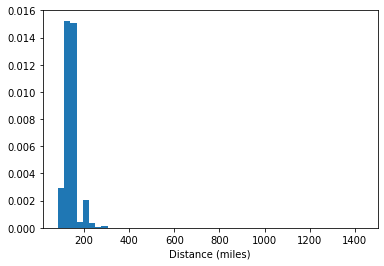

In [8]:
data = df[(df.ScDepTime > df.ScArrTime)]
_ = pp.hist(data.Dist, bins=np.linspace(data.Dist.min(), data.Dist.max(), 50), density=True)
_ = pp.xlabel('Distance (miles)')

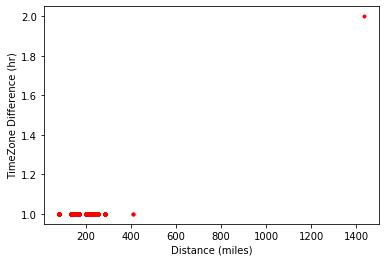

In [9]:
_ = pp.plot(data.Dist, -1 * data.TimeZoneDiff.astype('timedelta64[m]') / 60, 'r.')
_ = pp.xlabel('Distance (miles)')
_ = pp.ylabel('TimeZone Difference (hr)')

As it can be seen in the figure above, the distances of all flights that satisfy the condition, arrival time is earlier than departure time, is around 200 miles except one particular flight which is approximately 1400 miles. So, we remove that flight from our record.

In [10]:
idx = data[data.Dist == data.Dist.max()].index.values[0]
data[data.Dist == data.Dist.max()].iloc[:, range(8,31)]

,ScDepTime,DepTime,DepDelay,TxO,WhOff,WhOn,TxI,ScArrTime,ArrTime,ArrDelay,...,ScElaTime,AcElaTime,AirTime,Dist,CarrDel,WeaDel,NASDel,SecDel,LatAirDel,TimeZoneDiff
797803,2018-10-27 17:20:00,2018-10-27 17:18:00,-1 days +23:58:00,00:13:00,2018-10-27 17:31:00,2018-10-27 18:56:00,00:06:00,2018-10-27 17:18:00,2018-10-27 19:02:00,01:44:00,...,01:58:00,03:44:00,03:25:00,1433,0,0,104,0,0,-1 days +22:00:00


In [11]:
df.drop(idx, inplace=True)

In [12]:
print(df[(df.CnclCd != 0)].shape[0], df[df.Cncl == 1].shape[0]) 
df[(df.Cncl == 1) & (df.CnclCd == 0)]

102053 102055


,WeekDay,IATA,TailNum,FlightNum,OrgAirID,OrgMarID,DestAirID,DestMarID,ScDepTime,DepTime,...,ScElaTime,AcElaTime,AirTime,Dist,CarrDel,WeaDel,NASDel,SecDel,LatAirDel,TimeZoneDiff
2887851,3,F9,N309FR,874,14027,34027,15356,35356,2018-03-21 17:42:00,NaT,...,02:39:00,NaT,NaT,985,0,0,0,0,0,00:00:00
4374927,7,YV,N85354,6345,12451,31136,12266,31453,2018-05-20 15:55:00,NaT,...,02:40:00,NaT,NaT,817,0,0,0,0,0,-1 days +23:00:00


There seems to be two flights whose cancellation code column is not consistent with cancel column. Those two records are also removed.

In [13]:
df.drop(df[(df.Cncl == 1) & (df.CnclCd == 0)].index.values, inplace=True)

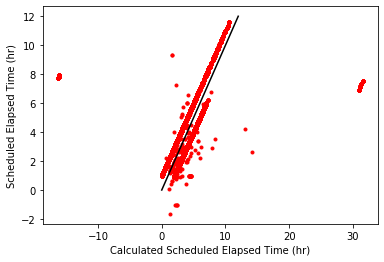

In [14]:
mask = (df.ScArrTime - df.ScDepTime - df.TimeZoneDiff - df.ScElaTime)
cond = (mask != pd.Timedelta('0 hours'))
x = df.loc[cond, 'ScArrTime'] - df.loc[cond, 'ScDepTime'] - df.loc[cond, 'TimeZoneDiff']
y = df.loc[cond, 'ScElaTime']
_ = pp.plot(x.astype('timedelta64[m]')/60, y.astype('timedelta64[m]')/60, 'r.', np.array([0, 12]), np.array([0,12]), 'k-')
_ = pp.xlabel('Calculated Scheduled Elapsed Time (hr)')
_ = pp.ylabel('Scheduled Elapsed Time (hr)')

Many data points are 1 hour off from 1:1 line, black straight line. The reason why there data points are 1 hour away from black line is because time zone difference column does not account for day light savings time. For example, Arizona state does not use day light savings time whereas other states do. So, to solve this problem, we update data points where it is only 1 hour off from 1:1 line. The outliers on the left and right side of the figure are coming from an airport located at Guam Island where it is over international date line. We also removed any flights from/to Guam Island.

In [15]:
# Drop any flights from/to Guam Island, since international day line is passed
idx = df[(df.OrgAirID == 12016) | (df.DestAirID == 12016)].index
df.drop(idx, inplace=True)

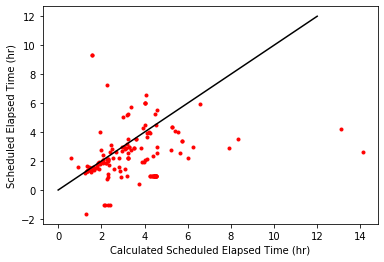

In [16]:
cond = cond & (mask.abs() == pd.Timedelta('1 hours'))
df.loc[cond, 'TimeZoneDiff'] = df.loc[cond, 'ScArrTime'] - df.loc[cond, 'ScDepTime'] - df.loc[cond, 'ScElaTime']
mask = (df.ScArrTime - df.ScDepTime - df.TimeZoneDiff - df.ScElaTime)
cond = (mask != pd.Timedelta('0 hours'))
x = df.loc[cond, 'ScArrTime'] - df.loc[cond, 'ScDepTime'] - df.loc[cond, 'TimeZoneDiff']
y = df.loc[cond, 'ScElaTime']
_ = pp.plot(x.astype('timedelta64[m]')/60, y.astype('timedelta64[m]')/60, 'r.', np.array([0, 12]), np.array([0,12]), 'k-')
_ = pp.xlabel('Calculated Scheduled Elapsed Time (hr)')
_ = pp.ylabel('Scheduled Elapsed Time (hr)')

In [17]:
df.drop(x.index, inplace=True)

In [18]:
integrity.check(df)

WeekDay column passed check
IATA column passed check
TailNum column passed check
FlightNum column passed check
OrgAirID column passed check
OrgMarID column passed check
DestAirID column passed check
DestMarID column passed check
ScDepTime column passed check
***A flight(s) is/are scheduled later than ScArrTime***
DepTime column passed check (1/2)
DepTime column passed check (2/2)
WhOff column passed check
TxO column passed check (1/2)
TxO column passed check (2/2)
ScArrTime column passed check
ArrTime column passed check (1/2)
ArrTime column passed check (2/2)
WhOn column passed check
TxI column passed check (1/2)
TxI column passed check (2/2)
Cncl column passed check (1/2)
Div column passed check (1/2)
Cncl/Div columns passed check (2/2)
CnclCd column passed check
ScElaTime column passed check (1/2)
ScElaTime column passed check (2/2)
***AcElaTime has null entries other than cancelled/diverted flights***
***AcElaTime is not equal to ArrTime - DepTime - TimeZoneDiff***
***AirTime has n

In [19]:
df[(df.AcElaTime.isnull()) & (df.Cncl == 0) & (df.Div == 0)]

,WeekDay,IATA,TailNum,FlightNum,OrgAirID,OrgMarID,DestAirID,DestMarID,ScDepTime,DepTime,...,ScElaTime,AcElaTime,AirTime,Dist,CarrDel,WeaDel,NASDel,SecDel,LatAirDel,TimeZoneDiff
3207896,4,YX,N880RW,6103,12953,31703,11298,30194,2018-03-01 09:55:00,2018-03-01 09:52:00,...,04:31:00,NaT,NaT,1389,0,0,0,0,0,-1 days +23:00:00


Actual Elapsed Time column has a null entry(ies) when a flight(s) is not cancelled or diverted. This is odd. That's why we are removing this flight as well.

In [20]:
df.drop(df[(df.AcElaTime.isnull()) & (df.Cncl == 0) & (df.Div == 0)].index, inplace=True)

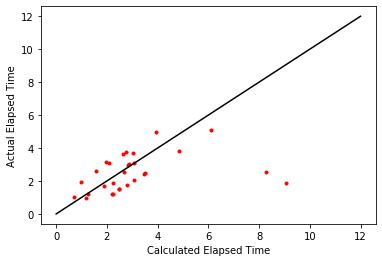

In [21]:
mask = (df.ArrTime - df.DepTime - df.TimeZoneDiff - df.AcElaTime)
cond = (mask != pd.Timedelta('0 hours')) & (df.Cncl == 0) & (df.Div == 0)
x = df.loc[cond, 'ArrTime'] - df.loc[cond, 'DepTime'] - df.loc[cond, 'TimeZoneDiff']
y = df.loc[cond, 'AcElaTime']
_ = pp.plot(x.astype('timedelta64[m]')/60, y.astype('timedelta64[m]')/60, 'r.', np.array([0, 12]), np.array([0,12]), 'k-')
_ = pp.xlabel('Calculated Elapsed Time')
_ = pp.ylabel('Actual Elapsed Time')

In [22]:
x.head()

2646031   01:16:00
2882863   02:49:00
2884127   03:05:00
3209238   02:38:00
3049181   02:11:00
dtype: timedelta64[ns]

Actual Elapsed Time column needs to be equal to Arrival Time - Departure Time - TimeZoneDifference. The red data points above show flight records that does not satisfy this equation. So, we remove them. Note that it is hard to update timezone difference in this case because there is no systematic differences between x values, ArrTime - DepTime - TimeZoneDiff, vs y values, Actual Elapsed Time.

In [23]:
df.drop(x.index, inplace=True)

In [24]:
integrity.check(df)

WeekDay column passed check
IATA column passed check
TailNum column passed check
FlightNum column passed check
OrgAirID column passed check
OrgMarID column passed check
DestAirID column passed check
DestMarID column passed check
ScDepTime column passed check
***A flight(s) is/are scheduled later than ScArrTime***
DepTime column passed check (1/2)
DepTime column passed check (2/2)
WhOff column passed check
TxO column passed check (1/2)
TxO column passed check (2/2)
ScArrTime column passed check
ArrTime column passed check (1/2)
ArrTime column passed check (2/2)
WhOn column passed check
TxI column passed check (1/2)
TxI column passed check (2/2)
Cncl column passed check (1/2)
Div column passed check (1/2)
Cncl/Div columns passed check (2/2)
CnclCd column passed check
ScElaTime column passed check (1/2)
ScElaTime column passed check (2/2)
AcElaTime column passed check (1/2)
AcElaTime column passed check (2/2)
AirTime column passed check (1/2)
AirTime column passed check (2/2)


As a last integrity check, the data passed all points except one point. But, we allowed that ScArrTime is earlier than SCDepTime due to short distance with 1 hour timezone difference.

In [25]:
df.isnull().sum()

WeekDay              0
IATA                 0
TailNum              0
FlightNum            0
OrgAirID             0
OrgMarID             0
DestAirID            0
DestMarID            0
ScDepTime            0
DepTime         102036
DepDelay        102036
TxO             102036
WhOff           102036
WhOn            119830
TxI             119830
ScArrTime            0
ArrTime         119830
ArrDelay        119830
Cncl                 0
CnclCd               0
Div                  0
ScElaTime            0
AcElaTime       119830
AirTime         119830
Dist                 0
CarrDel              0
WeaDel               0
NASDel               0
SecDel               0
LatAirDel            0
TimeZoneDiff         0
dtype: int64

The number of null entries is consistent with the number of cancelled or diverted flights.

In [28]:
df.sort_values('ScDepTime', inplace=True) # Sort by ScDepTime

In [27]:
rows_ = len(df)
print('Number of deleted entries: {}'.format(rows-rows_))

Number of deleted entries: 15945


Number of deleted entries is relatively small compared to total number of rows.

In [27]:
df = weather.data(df, airport, icao, date_start, date_end)

100% (356 of 356) |######################| Elapsed Time: 1:22:05 ETA:  00:00:00


Done!
